In [1]:
import os.path
import torch.optim as optim
from torch.utils.data import DataLoader
import dsntnn
import json
import pickle
from tqdm import tqdm
from utils import *
from models import CoordRegressionNetwork

#### Params

In [2]:
np.random.seed(1)
torch.manual_seed(1)

dataset = "BNC"

# Using CPU to prove training efficiency
torch.device = "cpu"

# Geometric Params
init_t = [0, 0, 150]            # Initial translation for PnP (millimeter)
init_r = [0, 0, 0]              # Initial rotation for PnP (rodriguez rotation)
rotation = None                 # Rotation of image during image augmentation
h_flip_indices = [2, 1, 0, 3]   # Indices to get correct order of kpts after horizontal flip
v_flip_indices = [0, 3, 2, 1]   # Indices to get correct order of kpts after vertical flip
xy_indices = np.array([1, 2])   # Indices for translation vector that correspond with image plane

# Learning Parameters
bs = 4                          # Batch size
sigma_t = 5                     # Sigma for Jason-Shannon divergence of heatmaps (see dsntnn docu for more)
lr = 5e-4                       # Learning rate
lr_reduced = 5e-5               # Reduced learning rate
epochs = 30                     # Maximum training epochs
epochs_reduced = 10             # Amount of epochs to train with a reduced learning rate
n_split = [80, 20, 100]         # Amount of train, val, and test images
val_epoch_interval = 2          # Validate model every _ epochs
crop_size = [500, 500]          # Width, height of image after cropping
resize_hw = [100, 100]          # Resize image before feeding into model
dist_pad = [30, 30, 30, 30]     # Minimum distance in pixels between keypoint and boundary of image before cropping


### Build Datasets

In [3]:
# Load dataset
path_data = os.path.join(os.path.dirname(os.path.abspath('')), 'data', dataset)
path_images = os.path.join(path_data, 'images')
path_backgrounds = os.path.join(path_data, 'backgrounds')
img_names = np.array([e for e in os.listdir(path_images) if e[-4:] == ".png"])
img_paths = np.array([os.path.join(path_images, e) for e in img_names])
bckgnd_names = np.array([os.path.join(path_backgrounds, e) for e in os.listdir(path_backgrounds) if e[-4:] == ".png"])
kpts_2d = json.load(open(os.path.join(path_data, 'keypoints_2d.json'), "r"))
kpts_3d = json.load(open(os.path.join(path_data, 'keypoints_3d.json'), "r"))["P"]
kpts_3d = torch.tensor(kpts_3d).to(torch.float)
n_kpts = len(kpts_3d)
h_cam_in_params = json.load(open(os.path.join(path_data, 'h_cam_intern.json'), "r"))
h_cam_in = get_h_cam_in_pinhole(h_cam_in_params)
robot_poses = json.load(open(os.path.join(path_data, 'robot_poses.json'), "r"))

# Initialize WorldPoseTransformer, Reproject estimated points
pose_transformer = WorldPoseTransformer(pts_3d=kpts_3d, h_cam_intern=h_cam_in, rvec=init_r, tvec=init_t,
                                        h_from_rob_pose_function=h_from_ur_pose)
rpj_pts_2d = pose_transformer.reproject_points(rob_poses=robot_poses, pts_2d=kpts_2d, ignore_rotation=True)
mean_err = pose_transformer.get_mean_xyz_error()
print(f"Mean deviations of object poses from annotated keypoints (translations): " +
      f"{mean_err[xy_indices[0]]:.3f}mm, {mean_err[xy_indices[1]]:.3f}mm")

# Build arrays from dicts
arr_robot_poses = np.array([robot_poses[img_name] for img_name in img_names])
arr_pts_2d = np.array([rpj_pts_2d[img_name] for img_name in img_names])

# Split dataset
indices = np.linspace(0, len(img_paths)-1, len(img_paths)).astype(int)
labeled_idx = [i for i in indices if img_names[i] in kpts_2d.keys()]
i_train = n_split[0] - len(labeled_idx)
indices = [i for i in indices if i not in labeled_idx]
train_idx = indices[:i_train] + labeled_idx
val_idx = indices[i_train:n_split[1]+i_train]
test_idx = indices[-n_split[2]:]

# Transformations
img_pipeline_train = ImgProcessingPipeline(
    rotate=rotation, h_flip_idx=h_flip_indices, v_flip_idx=v_flip_indices, rot90_idx=None,
    buffer_distances=dist_pad, crop_size_wh=crop_size, resize_wh=resize_hw, background_paths=bckgnd_names,
    basic_aug=True)

img_pipeline_val_test = ImgProcessingPipeline(
    buffer_distances=dist_pad, crop_size_wh=crop_size, resize_wh=resize_hw, basic_aug=False, affine_aug=False)

# Dataset for training
train_ds = Dataset(img_paths=img_paths[train_idx], transform=img_pipeline_train, kpts2d=arr_pts_2d[train_idx])
train_dl = DataLoader(dataset=train_ds, batch_size=bs, shuffle=True)

val_ds = Dataset(img_paths=img_paths[val_idx], transform=img_pipeline_val_test, kpts2d=arr_pts_2d[val_idx],
                 rob_poses=arr_robot_poses[val_idx], augment_onthefly=False)
val_dl = DataLoader(dataset=val_ds, batch_size=1, shuffle=False)

test_ds = Dataset(img_paths=img_paths[test_idx], transform=img_pipeline_val_test, kpts2d=arr_pts_2d[test_idx],
                  rob_poses=arr_robot_poses[test_idx], augment_onthefly=False)
test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False)

Mean deviations of object poses from annotated keypoints (translations): 0.031mm, 0.023mm


### Training

In [4]:
model = CoordRegressionNetwork(n_out=n_kpts)
_ = print_net_info(model, size=resize_hw)
optimizer = optim.Adam(params=model.parameters(), lr=lr)
train_loss = []
val_loss = []
val_loss_i = []
best_val_loss = np.inf
path_weights, path_loss, path_imgs = create_results_paths(dataset)
for i_epoch in tqdm(range(epochs)):
    # Iterate training data
    running_loss_train = 0
    model.train(True)
    # Reduce Learning rate after x epochs
    if i_epoch + 1 == epochs - epochs_reduced:
        for g in optimizer.param_groups:
            g['lr'] = lr_reduced
    # Training
    for i, (img, pts_2d_gt_c_n, offsets) in enumerate(train_dl):
        bs = img.shape[0]
        # Forward pass
        pts_est, heatmaps = model(img)
        # Loss
        reg_losses = dsntnn.js_reg_losses(heatmaps, pts_2d_gt_c_n.view(bs, n_kpts, 2), sigma_t=sigma_t)
        euc_losses = dsntnn.euclidean_losses(pts_est, pts_2d_gt_c_n.view(bs, n_kpts, 2))
        loss = dsntnn.average_loss(euc_losses + reg_losses)
        running_loss_train += loss.item()
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(running_loss_train / i)
    # Iterate validation data
    if (i_epoch + 1) % val_epoch_interval == 0:
        model.eval()
        pose_transformer.reset_log()
        with torch.no_grad():
            for i, (img, kpts, offsets, rob_pose) in enumerate(val_dl):
                # Forward pass
                pts_est, heatmaps = model(img)
                # Denorm, desize, decrop
                pts_est_decoded = decode_pred_pts(pts_est, [resize_hw[1], resize_hw[0]], crop_size, offsets)
                # Track loss
                pose_transformer(pts_est_decoded, rob_pose.squeeze(0).squeeze(0).detach().numpy())
            # Log loss
            mean_error = pose_transformer.get_mean_xyz_error()[xy_indices]
            val_loss.append(np.mean(mean_error))
            val_loss_i.append(i_epoch)
        # Save if best model
        if val_loss[-1] < best_val_loss:
            best_val_loss = val_loss[-1]
            torch.save(model.state_dict(), path_weights)
        # Print info
        mean_train_loss = np.mean(train_loss[-val_epoch_interval:])
        print(f'Epoch {i_epoch+1}: \tTrain loss: {mean_train_loss:.3f} \tVal loss: {val_loss[-1]:.2f} in mm')

Start Training with 826k trainable params
A forward pass with 1 image takes 0.053 sec
CUDA available: False


  7%|██▉                                         | 2/30 [00:16<04:00,  8.58s/it]

Epoch 2: 	Train loss: 1.055 	Val loss: 1.91 in mm


 13%|█████▊                                      | 4/30 [00:30<03:16,  7.57s/it]

Epoch 4: 	Train loss: 0.876 	Val loss: 1.92 in mm


 20%|████████▊                                   | 6/30 [00:44<02:51,  7.13s/it]

Epoch 6: 	Train loss: 0.554 	Val loss: 0.36 in mm


 27%|███████████▋                                | 8/30 [00:57<02:33,  6.99s/it]

Epoch 8: 	Train loss: 0.248 	Val loss: 0.18 in mm


 33%|██████████████▎                            | 10/30 [01:11<02:17,  6.88s/it]

Epoch 10: 	Train loss: 0.104 	Val loss: 0.08 in mm


 40%|█████████████████▏                         | 12/30 [01:27<02:20,  7.82s/it]

Epoch 12: 	Train loss: 0.073 	Val loss: 0.09 in mm


 47%|████████████████████                       | 14/30 [01:45<02:10,  8.18s/it]

Epoch 14: 	Train loss: 0.064 	Val loss: 0.11 in mm


 53%|██████████████████████▉                    | 16/30 [01:58<01:43,  7.40s/it]

Epoch 16: 	Train loss: 0.049 	Val loss: 0.07 in mm


 60%|█████████████████████████▊                 | 18/30 [02:10<01:19,  6.63s/it]

Epoch 18: 	Train loss: 0.048 	Val loss: 0.16 in mm


 67%|████████████████████████████▋              | 20/30 [02:21<01:01,  6.13s/it]

Epoch 20: 	Train loss: 0.042 	Val loss: 0.08 in mm


 73%|███████████████████████████████▌           | 22/30 [02:34<00:50,  6.28s/it]

Epoch 22: 	Train loss: 0.035 	Val loss: 0.07 in mm


 80%|██████████████████████████████████▍        | 24/30 [02:55<00:51,  8.51s/it]

Epoch 24: 	Train loss: 0.034 	Val loss: 0.07 in mm


 87%|█████████████████████████████████████▎     | 26/30 [03:08<00:29,  7.48s/it]

Epoch 26: 	Train loss: 0.034 	Val loss: 0.07 in mm


 93%|████████████████████████████████████████▏  | 28/30 [03:22<00:14,  7.12s/it]

Epoch 28: 	Train loss: 0.032 	Val loss: 0.06 in mm


100%|███████████████████████████████████████████| 30/30 [03:34<00:00,  7.14s/it]

Epoch 30: 	Train loss: 0.032 	Val loss: 0.06 in mm


### Loss curve

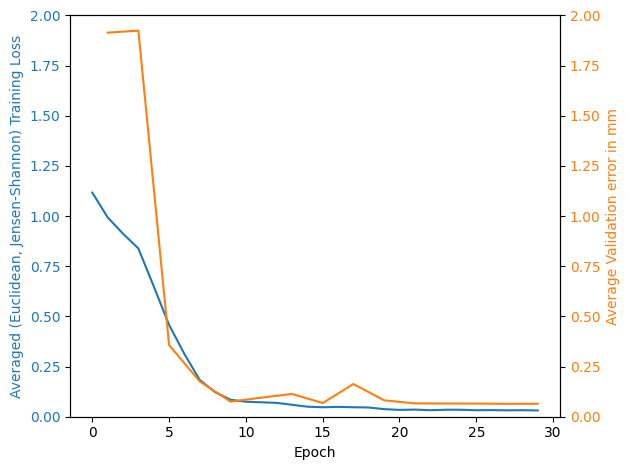

In [5]:
plot_loss_curves(train_loss, val_loss, val_loss_i, path_loss)

### Test

In [6]:
    model.load_state_dict(torch.load(path_weights))
    model.eval()
    pose_transformer.reset_log()
    with torch.no_grad():
        for i, (img, kpts, offsets, rob_pose) in enumerate(test_dl):
            # Forward pass
            pts_est, heatmaps = model(img)
            # Denorm, desize, decrop
            pts_est_decoded = decode_pred_pts(pts_est, [resize_hw[1], resize_hw[0]], crop_size, offsets)
            # Track loss
            pose_transformer(pts_est_decoded, rob_pose.squeeze(0).squeeze(0).detach().numpy())
            # Save prediction
            pts_est_decoded_nocrop = decode_pred_pts(pts_est, [resize_hw[1], resize_hw[0]], crop_size)
            save_prediction(img, pts_est_decoded_nocrop, path_n_name=os.path.join(path_imgs, f'{i}.png'))
    # Print test statistics
    mean_error = pose_transformer.get_mean_xyz_error()
    max_error = pose_transformer.get_max_xyz_error()
    print(f'Mean XY pose error:\t{mean_error[xy_indices[0]]:.3f} mm\t{mean_error[xy_indices[1]]:.3f} mm')
    print(f'Max XY pose error:\t{max_error[xy_indices[0]]:.3f} mm\t{max_error[xy_indices[1]]:.3f} mm')

Mean XY pose error:	0.055 mm	0.048 mm
Max XY pose error:	0.165 mm	0.156 mm


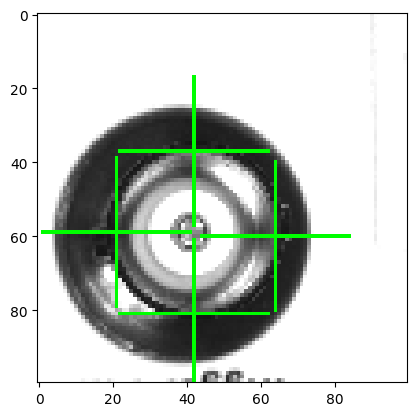

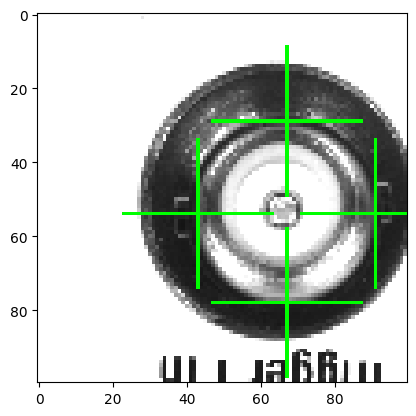

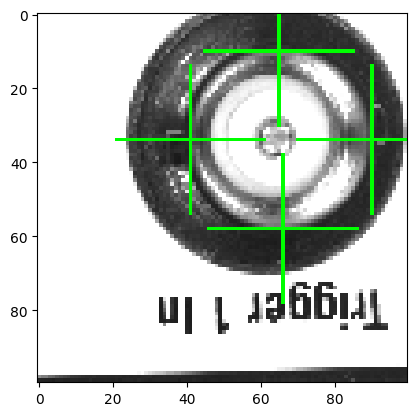

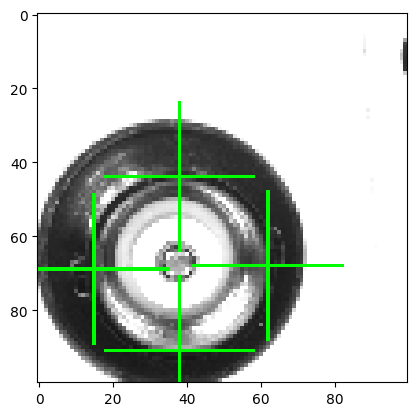

In [7]:
for i in [0,2,3,12]:
    plt.figure()
    img = cv.imread(os.path.join(path_imgs, f'{i}.png'))
    plt.imshow(img)